In [12]:
%%capture
%pip install nfl-data-py --quiet

In [13]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [14]:
weekly_df = nfl.import_weekly_data(years=range(2000, 2022))

Downcasting floats.


In [15]:
weekly_df.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,IND,2000,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,-0.2,-0.2
1,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,1,REG,...,0.0,-0.312120,0,0.0,0.045455,NaN,NaN,0.0,0.3,1.3
2,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,12,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.8,1.8
3,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,14,REG,...,1.0,0.609493,0,0.0,0.071429,NaN,NaN,0.0,4.9,5.9
4,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,15,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.4,1.4


In [35]:
# making three
eligible_positions = ['WR', 'RB', 'QB']
grouping_columns = ['player_id', 'season']
features = ['targets', 'receptions', 'rushing_yards', 'receiving_yards', 'passing_yards']
target = ['position']

train_df = weekly_df.loc[weekly_df['position'].isin(eligible_positions), grouping_columns + features + target]


# grouping by season instead of week
groupby_funcs = {
    'position': 'first'
}

for feature in features:
    groupby_funcs[feature] = np.sum

train_df = train_df.groupby(grouping_columns, as_index=False).agg(groupby_funcs)

train_df['position'] = train_df['position'].replace({
    'RB':0,
    'WR':1,
    'QB':2
})

# setting parameters for minimum stats required for position

train_df = train_df.loc[(train_df['rushing_yards'] > 200) | (train_df['passing_yards'] > 300) |(train_df['receiving_yards'] > 150)]                                               
train_df.head()


,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards
5,00-0000104,2000,2,0,0,13.0,0.0,1616.0
6,00-0000145,2000,1,134,72,45.0,1265.0,0.0
7,00-0000145,2001,1,68,27,16.0,470.0,0.0
9,00-0000210,2000,0,60,39,1106.0,291.0,0.0
10,00-0000210,2001,0,45,31,476.0,212.0,0.0


In [24]:
train_df['position'].unique()

array(['RB', 'QB', 'WR'], dtype=object)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[features],
    train_df[target],
    test_size=0.2,
    random_state=123
)


,targets,receptions,rushing_yards,receiving_yards,passing_yards
5418,139,87,13.0,1072.0,0.0
2017,126,67,0.0,831.0,0.0
840,13,11,436.0,79.0,0.0
8837,82,50,10.0,655.0,0.0
7942,6,4,374.0,52.0,978.0
...,...,...,...,...,...
8515,0,0,222.0,0.0,2527.0
6516,47,21,5.0,262.0,0.0
2057,47,24,0.0,367.0,0.0
5540,131,74,59.0,1178.0,0.0


In [44]:
# Creating a decision tree classifier with a max depth of 2
clf = DecisionTreeClassifier(max_depth=2)


# Fitting the data using x_train and y_train
clf.fit(X_train, y_train)

# making a variable to predict against the y_test
y_pred = clf.predict(X_test)

y_pred

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9853076216712581


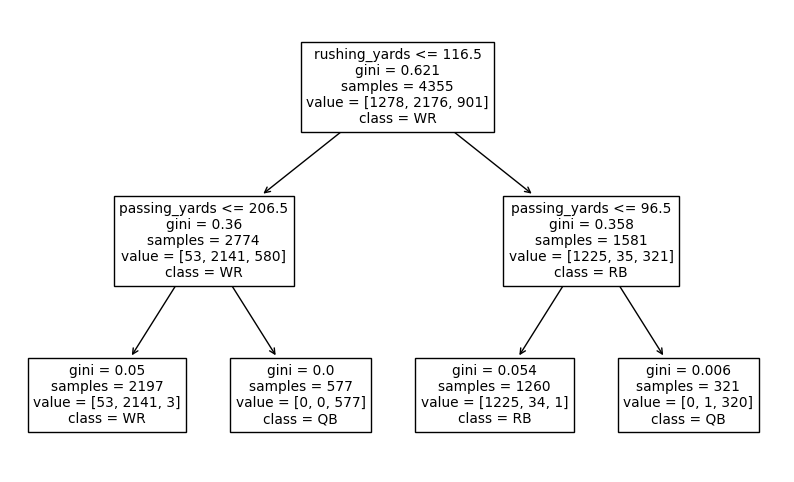

In [47]:
fig, ax = plt.subplots(figsize=(10,6))

class_names = ['RB', 'WR', 'QB']


# Left is true right is false for the first variable rushing_yards <= 116.5
plot_tree(clf, ax=ax, feature_names=features, class_names=class_names);

In [55]:
params = {
    'max_depth': range(1,10),
    'min_samples_split': range(2,6),
        }
clf = DecisionTreeClassifier()

# applies 10 fold cross validation, splits data into 90% training, 10% test
grid_search = GridSearchCV(clf, params, cv=10)

grid_search.fit(train_df[features],train_df[target])

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_split': range(2, 6)})

In [64]:
best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print ('Best Parameters:', best_params)

Best Parameters: {'max_depth': 5, 'min_samples_split': 3}


In [60]:
best_clf

DecisionTreeClassifier(max_depth=5, min_samples_split=3)

In [63]:
print('Best Score:', best_score)

Best Score: 0.9838336481381544


In [66]:
# RB = 0, WR = 1,  QB = 2 
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.head()

,precision,recall,f1-score,support
0,0.985075,0.967742,0.976331,341.000000
1,0.979554,0.994340,0.986891,530.000000
2,1.000000,0.990826,0.995392,218.000000
accuracy,0.985308,0.985308,0.985308,0.985308
macro avg,0.988210,0.984302,0.986205,1089.000000


1089